In [7]:
import numpy as np
from tqdm import tqdm
from importlib import reload
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import scipy
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read data

In [8]:
xr_primap = xr.open_dataset("X:/user/dekkerm/Data/PRIMAP/Guetschow_et_al_2023b-PRIMAP-hist_v2.5_final_no_rounding_15-Oct-2023.nc")
xr_primap2 = xr.open_dataset("X:/user/dekkerm/Data/PRIMAP/Guetschow_et_al_2024-PRIMAP-hist_v2.5.1_final_no_rounding_27-Feb-2024.nc")

In [9]:
df_lulucf = pd.read_excel('X:/user/dekkerm/Data/EDGAR/essd_lulucf_data.xlsx', sheet_name='data')
xr_edgar = xr.Dataset.from_dataframe(df_lulucf.drop(columns=['region_ar6_6', 'mean']).set_index(['year', 'region_ar6_10']))

In [10]:
import class_datareading
reload(class_datareading)
from class_datareading import datareading

datareader = datareading()
datareader.read_general()
df_nwc = pd.read_csv('X:/user/dekkerm/Data/NationalWarningContributions/EMISSIONS_ANNUAL_1830-2022.csv')
xr_nwc = xr.Dataset.from_dataframe(df_nwc.drop(columns=['CNTR_NAME', 'Unit']).set_index(['ISO3', 'Gas', 'Component', 'Year']))

# ==================================== #
# Initializing datareading class     #
# ==================================== #
- Reading general data


In [73]:
xr_nwc

<xarray.Dataset>
Dimensions:    (ISO3: 232, Gas: 3, Component: 3, Year: 193)
Coordinates:
  * ISO3       (ISO3) object 'ABW' 'AFG' 'AGO' 'AIA' ... 'YEM' 'ZAF' 'ZMB' 'ZWE'
  * Gas        (Gas) object 'CH[4]' 'CO[2]' 'N[2]*O'
  * Component  (Component) object 'Fossil' 'LULUCF' 'Total'
  * Year       (Year) int64 1830 1831 1832 1833 1834 ... 2019 2020 2021 2022
Data variables:
    Data       (ISO3, Gas, Component, Year) float64 nan nan ... 0.01819 0.01817

In [59]:
xr_nwc_tot = (xr_nwc.sel(Gas='CH[4]')*datareader.settings['params']['gwp_ch4']/1e3+xr_nwc.sel(Gas='N[2]*O')*datareader.settings['params']['gwp_n2o']/1e3+xr_nwc.sel(Gas='CO[2]')*1).drop_vars(['Gas'])
#xr_nwc_tot = (xr_nwc.sel(Gas='CH[4]')*27.9/1e3+xr_nwc.sel(Gas='N[2]*O')*datareader.settings['params']['gwp_n2o']/1e3+xr_nwc.sel(Gas='CO[2]')*1).drop_vars(['Gas'])

Text(0.5, 1.0, 'World, only CO2')

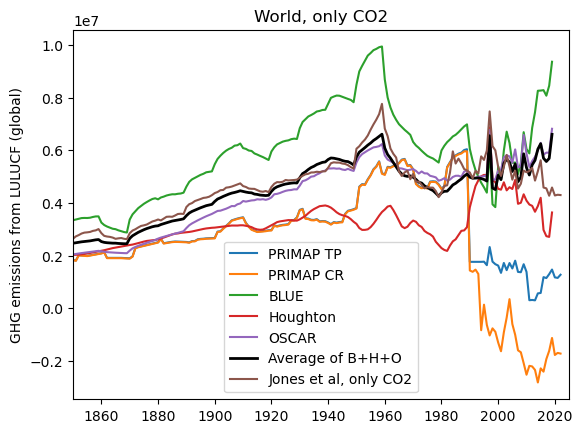

In [30]:
plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['CO2'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region='EARTH', scen='HISTTP', provenance='derived', cat='M.LULUCF')), label='PRIMAP TP')
plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['CO2'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region='EARTH', scen='HISTCR', provenance='derived', cat='M.LULUCF')), label='PRIMAP CR')

plt.plot(xr_edgar.year, xr_edgar.sum(dim='region_ar6_10').blue/1e3, label='BLUE')
plt.plot(xr_edgar.year, xr_edgar.sum(dim='region_ar6_10').houghton/1e3, label='Houghton')
plt.plot(xr_edgar.year, xr_edgar.sum(dim='region_ar6_10').oscar/1e3, label='OSCAR')
plt.plot(xr_edgar.year, (xr_edgar.sum(dim='region_ar6_10').oscar/1e3+xr_edgar.sum(dim='region_ar6_10').blue/1e3+xr_edgar.sum(dim='region_ar6_10').houghton/1e3)/3, label='Average of B+H+O', c='k', lw=2)
#plt.plot(xr_nwc_tot.Year, xr_nwc_tot.sel(ISO3='GLOBAL', Component='LULUCF').Data*1e6, label='Jones et al')
plt.plot(xr_nwc_tot.Year, xr_nwc.sel(ISO3='GLOBAL', Component='LULUCF', Gas='CO[2]').Data*1e6, label='Jones et al, only CO2')


plt.ylabel('GHG emissions from LULUCF (global)')
plt.legend()
plt.xlim([1850, 2025])
plt.title('World, only CO2')

#plt.plot(xr_primap2.time, np.array(xr_primap['KYOTOGHG (AR4GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region='EARTH', scen='HISTTP', provenance='measured', cat='M.LULUCF')))


Text(0.5, 1.0, 'World, all GHG')

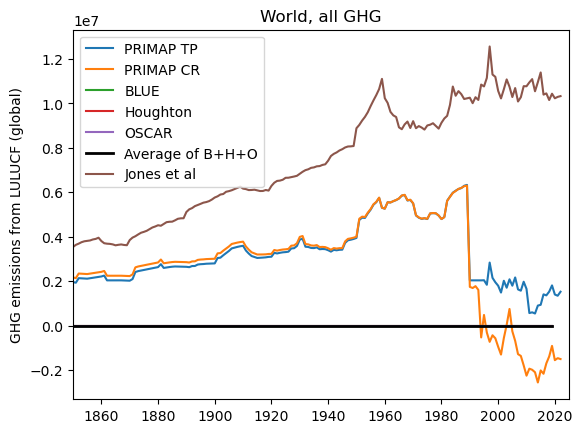

In [31]:
plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region='EARTH', scen='HISTTP', provenance='derived', cat='M.LULUCF')), label='PRIMAP TP')
plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region='EARTH', scen='HISTCR', provenance='derived', cat='M.LULUCF')), label='PRIMAP CR')

plt.plot(xr_edgar.year, 0*xr_edgar.sum(dim='region_ar6_10').blue/1e3, label='BLUE')
plt.plot(xr_edgar.year, 0*xr_edgar.sum(dim='region_ar6_10').houghton/1e3, label='Houghton')
plt.plot(xr_edgar.year, 0*xr_edgar.sum(dim='region_ar6_10').oscar/1e3, label='OSCAR')
plt.plot(xr_edgar.year, 0*(xr_edgar.sum(dim='region_ar6_10').oscar/1e3+xr_edgar.sum(dim='region_ar6_10').blue/1e3+xr_edgar.sum(dim='region_ar6_10').houghton/1e3)/3, label='Average of B+H+O', c='k', lw=2)
plt.plot(xr_nwc_tot.Year, xr_nwc_tot.sel(ISO3='GLOBAL', Component='LULUCF').Data*1e6, label='Jones et al')
#plt.plot(xr_nwc_tot.Year, xr_nwc.sel(ISO3='GLOBAL', Component='LULUCF', Gas='CO[2]').Data*1e6, label='Jones et al, only CO2')


plt.ylabel('GHG emissions from LULUCF (global)')
plt.legend()
plt.xlim([1850, 2025])
plt.title('World, all GHG')

#plt.plot(xr_primap2.time, np.array(xr_primap['KYOTOGHG (AR4GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region='EARTH', scen='HISTTP', provenance='measured', cat='M.LULUCF')))

#plt.xlim([2000, 2025])

Text(0.5, 1.0, 'World')

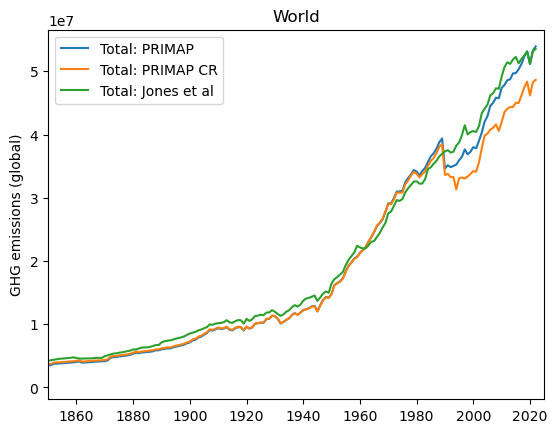

In [57]:
plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region='EARTH', scen='HISTTP', provenance='derived', cat=['M.LULUCF', 'M.0.EL']).sum(dim='cat')), label='Total: PRIMAP')
plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region='EARTH', scen='HISTCR', provenance='derived', cat=['M.LULUCF', 'M.0.EL']).sum(dim='cat')), label='Total: PRIMAP CR')
plt.plot(xr_nwc_tot.Year, xr_nwc_tot.sel(ISO3='GLOBAL', Component='Total').Data*1e6, label='Total: Jones et al')

# plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region='EARTH', scen='HISTTP', provenance='derived', cat=['M.0.EL']).sum(dim='cat')), label='Excl. LULUCF: PRIMAP')
# plt.plot(xr_nwc_tot.Year, xr_nwc_tot.sel(ISO3='GLOBAL', Component='Fossil').Data*1e6, label='Excl. LULUCF: Jones et al')

plt.ylabel('GHG emissions (global)')
plt.legend()
plt.xlim([1850, 2025])
plt.title('World')

Text(0.5, 1.0, 'World only LULUCF')

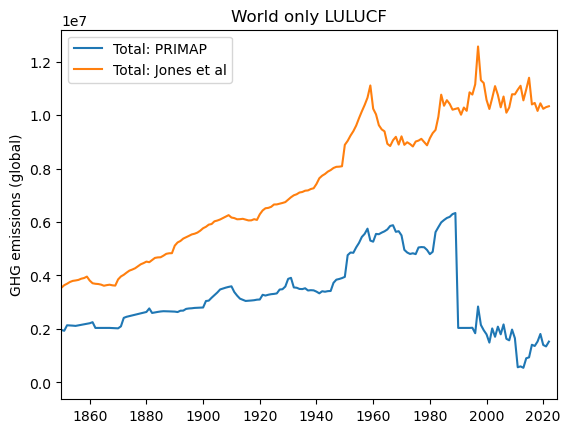

In [49]:
plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region='EARTH', scen='HISTTP', provenance='derived', cat=['M.LULUCF']).sum(dim='cat')), label='Total: PRIMAP')
plt.plot(xr_nwc_tot.Year, xr_nwc_tot.sel(ISO3='GLOBAL', Component='LULUCF').Data*1e6, label='Total: Jones et al')

# plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region='EARTH', scen='HISTTP', provenance='derived', cat=['M.0.EL']).sum(dim='cat')), label='Excl. LULUCF: PRIMAP')
# plt.plot(xr_nwc_tot.Year, xr_nwc_tot.sel(ISO3='GLOBAL', Component='Fossil').Data*1e6, label='Excl. LULUCF: Jones et al')

plt.ylabel('GHG emissions (global)')
plt.legend()
plt.xlim([1850, 2025])
plt.title('World only LULUCF')

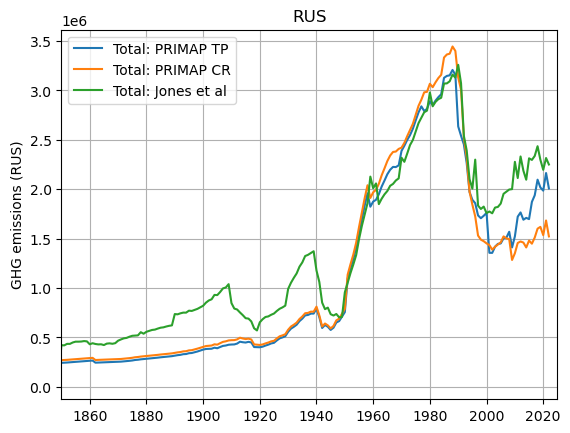

In [83]:
reg = 'RUS'

plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region=reg, scen='HISTTP', provenance='derived', cat=['M.LULUCF', 'M.0.EL']).sum(dim='cat')), label='Total: PRIMAP TP')
plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region=reg, scen='HISTCR', provenance='derived', cat=['M.LULUCF', 'M.0.EL']).sum(dim='cat')), label='Total: PRIMAP CR')
plt.plot(xr_nwc_tot.Year, xr_nwc_tot.sel(ISO3=reg, Component='Total').Data*1e6, label='Total: Jones et al')

# plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region=reg, scen='HISTTP', provenance='derived', cat=['M.0.EL']).sum(dim='cat')), label='Excl. LULUCF: PRIMAP')
# plt.plot(xr_nwc_tot.Year, xr_nwc_tot.sel(ISO3=reg, Component='Fossil').Data*1e6, label='Fossil: Jones et al')

plt.ylabel('GHG emissions ('+reg+')')
plt.legend()
plt.xlim([1850, 2025])
plt.title(reg)
plt.grid('on')

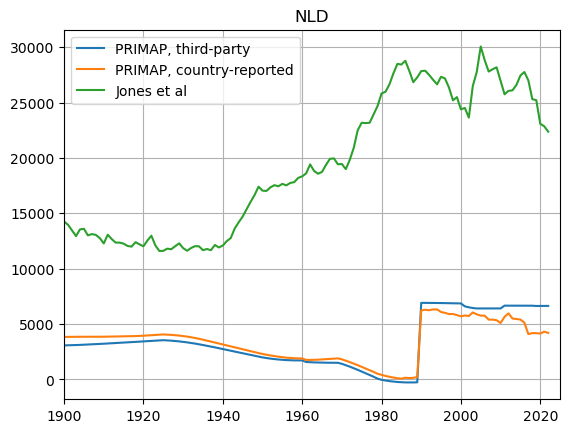

In [61]:
reg = 'NLD'

plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region=reg,scen='HISTTP', provenance='derived', cat='M.LULUCF')), label='PRIMAP, third-party')
plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region=reg, scen='HISTCR', provenance='derived', cat='M.LULUCF')), label='PRIMAP, country-reported')
plt.plot(xr_nwc_tot.Year, xr_nwc_tot.sel(ISO3=reg, Component='LULUCF').Data*1e6, label='Jones et al')
plt.xlim([1900, 2025])
plt.title(reg)
plt.legend()
plt.grid('on')

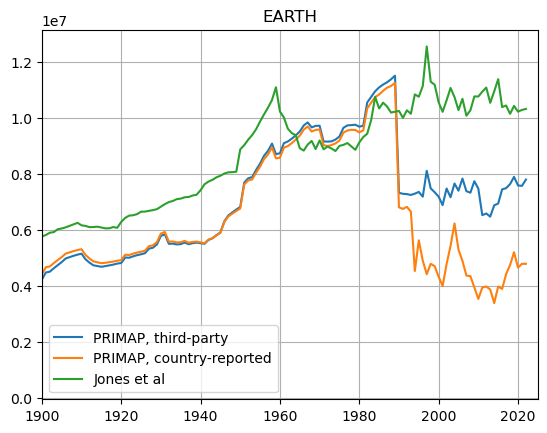

In [69]:
reg = 'EARTH'

plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region=reg,scen='HISTTP', provenance='derived', cat=['M.AG', 'M.LULUCF']).sum(dim='cat')), label='PRIMAP, third-party')
plt.plot([int(str(i)[:4]) for i in np.array(xr_primap2.time)], np.array(xr_primap2['KYOTOGHG (AR6GWP100)'].rename({'area (ISO3)': 'Region', 'scenario (PRIMAP-hist)': 'scen', 'category (IPCC2006_PRIMAP)': 'cat'}).sel(Region=reg, scen='HISTCR', provenance='derived', cat=['M.AG', 'M.LULUCF']).sum(dim='cat')), label='PRIMAP, country-reported')
plt.plot(xr_nwc_tot.Year, xr_nwc_tot.sel(ISO3='GLOBAL', Component='LULUCF').Data*1e6, label='Jones et al')
plt.xlim([1900, 2025])
plt.title(reg)
plt.legend()
plt.grid('on')

In [72]:
np.unique(df_nwc.Unit)

array(['Pg~CO[2]~year^-1', 'Tg~CH[4]~year^-1', 'Tg~N[2]*O~year^-1'],
      dtype=object)